<a href="https://colab.research.google.com/github/smitaforward/Data_Science/blob/master/Amazon_tensorflow2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow-gpu==2.0.0-alpha0
# !pip install tensorflow==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 50kB/s 
    100% |████████████████████████████████| 3.0MB 5.9MB/s 
    100% |████████████████████████████████| 61kB 19.4MB/s 
    100% |████████████████████████████████| 419kB 12.2MB/s 


In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [0]:
from tensorflow import keras
import numpy as np
import pandas as pd

# Amazon comments

## Data Readin

In [0]:
data_path = "https://s3.amazonaws.com/tomk/h2o-world/megan/AmazonReviews.csv"
data = pd.read_csv(data_path)

In [0]:
data.head()

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,These are made in China (do not buy ANY pet fo...
1,B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1323907200,"Everything is ok, except it just isn't as good..."
2,B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1310601600,Best cat treat ever. There isn't anything comp...
3,B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1316131200,My two Corgis were thoroughly spoiled by my la...
4,B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1334793600,We used to have drive down to the specialty pe...


In [0]:
label = []
for s in data['Score']:
  label.append(0 if s < 4 else 1)
data['Label'] = label

In [0]:
time_split = data['Time'].quantile(0.8)

In [0]:
data['Train']= data['Time'] < time_split

In [0]:
data.head()

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,Label,Train
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,These are made in China (do not buy ANY pet fo...,0,False
1,B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1323907200,"Everything is ok, except it just isn't as good...",0,True
2,B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1310601600,Best cat treat ever. There isn't anything comp...,1,True
3,B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1316131200,My two Corgis were thoroughly spoiled by my la...,1,True
4,B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1334793600,We used to have drive down to the specialty pe...,1,True


In [7]:
data.columns

Index(['ProductId', 'UserId', 'Summary', 'Score', 'HelpfulnessDenominator',
       'Id', 'ProfileName', 'HelpfulnessNumerator', 'Time', 'Text', 'Label',
       'Train'],
      dtype='object')

## Explore

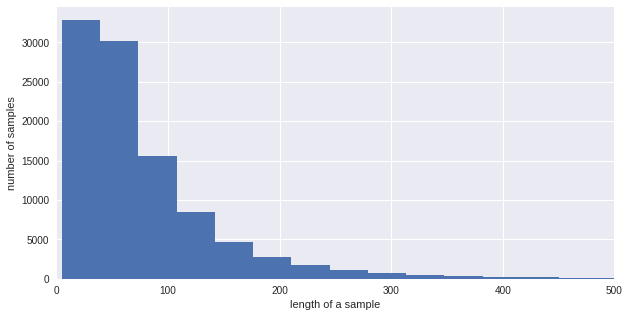

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.hist([len(s.split()) for s in data['Text']], 100)
plt.xlabel('length of a sample')
plt.xlim([0, 500])
plt.ylabel('number of samples')
plt.show()
  

In [0]:
data['Label'].value_counts()

1    78209
0    21791
Name: Label, dtype: int64

In [0]:
def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes


## Prep data

In [0]:
# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 300

In [0]:
def sequence_vectorize(train_texts, val_texts):
  tokenizer = keras.preprocessing.text.Tokenizer(num_words = TOP_K)
  tokenizer.fit_on_texts(train_texts)
  
  x_train = tokenizer.texts_to_sequences(train_texts)
  x_val = tokenizer.texts_to_sequences(val_texts)
  
  max_length = len(max(x_train, key = len))
  if max_length > MAX_SEQUENCE_LENGTH:
    max_length = MAX_SEQUENCE_LENGTH
  
  x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_length)
  x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen = max_length)
  return x_train, x_val, tokenizer.word_index

In [0]:
dt = ((data[data['Train'] == True]['Text'], data[data['Train'] == True]['Label']), (data[data['Train'] == False]['Text'], data[data['Train'] == False]['Label']))

(train_texts,train_labels), (val_texts, val_labels) = dt
x_train, x_val, word_index = sequence_vectorize(train_texts, val_texts)


## Build the model

In [0]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [0]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [0]:
num_features = min(len(word_index) + 1, TOP_K)
model = keras.Sequential([
    keras.layers.Embedding(num_features, 200),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = 'binary_crossentropy', 
              optimizer = 'adam',
              metrics = ['accuracy']
)

In [14]:
history = model.fit(x_train, train_labels, epochs=10,
                    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)],
                    validation_data = (x_val, val_labels))

Train on 79992 samples, validate on 20008 samples
Epoch 1/10
79992/79992 [==============================] - 2532s 32ms/sample - loss: 0.2960 - accuracy: 0.8758 - val_loss: 0.2740 - val_accuracy: 0.8837
Epoch 2/10
79992/79992 [==============================] - 2514s 31ms/sample - loss: 0.1889 - accuracy: 0.9272 - val_loss: 0.2830 - val_accuracy: 0.8961
Epoch 3/10
79992/79992 [==============================] - 2515s 31ms/sample - loss: 0.1328 - accuracy: 0.9511 - val_loss: 0.2833 - val_accuracy: 0.8879


## Train Your Model

In [0]:
Train Your Model

In [0]:
def train_sequence_model(data,
                         learning_rate=1e-3,
                         epochs=1000,
                         batch_size=128,
                         blocks=2,
                         filters=64,
                         dropout_rate=0.2,
                         embedding_dim=200,
                         kernel_size=3,
                         pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
#     num_classes = get_num_classes(train_labels)
    num_classes = 2
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val, word_index = sequence_vectorize(
            train_texts, val_texts)

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance.
    model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('amazon_sepcnn_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [0]:
dt = ((data[data['Train'] == True]['Text'], data[data['Train'] == True]['Label']), (data[data['Train'] == False]['Text'], data[data['Train'] == False]['Label']))

In [0]:
data[data['Train'] == True]['Label'].value_counts()

1    62861
0    17131
Name: Label, dtype: int64

In [0]:
train_sequence_model(dt)

Train on 79992 samples, validate on 20008 samples
Epoch 1/1000
79992/79992 - 269s - loss: 0.4459 - acc: 0.8161 - val_loss: 0.3158 - val_acc: 0.8733
Epoch 2/1000
79992/79992 - 266s - loss: 0.2584 - acc: 0.9012 - val_loss: 0.2986 - val_acc: 0.8884
Epoch 3/1000
79992/79992 - 265s - loss: 0.2054 - acc: 0.9234 - val_loss: 0.3041 - val_acc: 0.8925
Epoch 4/1000
79992/79992 - 265s - loss: 0.1716 - acc: 0.9377 - val_loss: 0.3364 - val_acc: 0.8870
Validation accuracy: 0.8870452046394348, loss: 0.3364130550744485


(0.8870452, 0.3364130550744485)

# Quick Example About CNN with - IMDB tokenized data

In [0]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)

17465344/17464789 [==============================] - 0s 0us/step


Explore the data

In [0]:
print(f'Training entries:{len(train_data)}, labels: {len(train_labels)}')

Training entries:25000, labels: 25000


In [0]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [0]:
print(len(train_data[0]), len(train_data[1]))

218 189


In [0]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

In [0]:
# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
  
decode_review(train_data[0])

"<START> in with i like horrible business chinese charm would killer waited which explosion ? going at fun ? film make like lame character has novel <UNK> a all final sense ? real ? find character nothing <UNK> second perhaps they ? find valuable cover this city an br overall ? horror has i ? should shop was in with ? delightful 00 despite ? with their people is i like horrible an well it br garbage ? with this genre this is i taken that <UNK> ? she sex is and house and after ? ? product bud i final which returned be ? does is i an annoying ? film where if at man it's film sent be ? with is comedy you than some ? in perfect i get <UNK> and ? think plot windows it fun ? <UNK> the lou ? sequence at their like horrible wanted on getting night just the ? <UNK> rich br any other ? couple it someone then he decade more on why ? can't ajay that ? family with for still wanted on final ? such his lindsay that if at you interesting how film any ? family would i an g other is i once ? i boot seen

Prep the data

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [0]:
print(len(train_data[0]), len(train_data[1]))

256 256


In [0]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## CNN Model

Build the model

In [0]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Train the model

In [0]:
# create validation set
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [0]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)],
                    validation_data=(x_val, y_val),
                    verbose=1) # means print out the training info

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 43s 3ms/sample - loss: 0.0760 - acc: 0.9769 - val_loss: 0.3449 - val_acc: 0.8861
Epoch 2/40
15000/15000 [==============================] - 43s 3ms/sample - loss: 0.0657 - acc: 0.9799 - val_loss: 0.3677 - val_acc: 0.8833
Epoch 3/40
15000/15000 [==============================] - 43s 3ms/sample - loss: 0.0559 - acc: 0.9831 - val_loss: 0.3927 - val_acc: 0.8816


Evaluate the model

In [0]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 40us/sample - loss: 0.3416 - accuracy: 0.8694
[0.3415939032173157, 0.86944]


Graph of accuracy and loss overtime

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

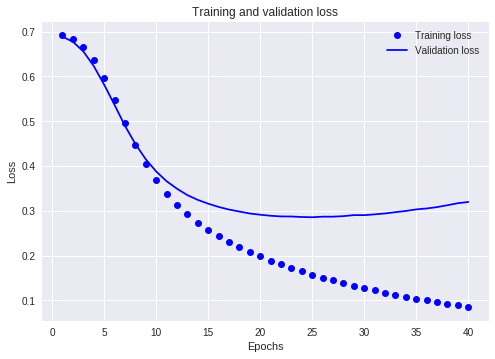

In [0]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

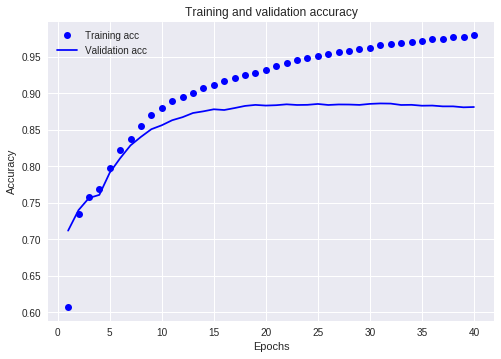

In [0]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## RNN

Build the model

In [0]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size,16),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 209,793
Trainable params: 209,793
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Training the model

In [0]:
# create validation set
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [0]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)],
                    validation_data=(x_val, y_val),
                    verbose=1) # means print out the training info

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 83s 6ms/sample - loss: 0.6849 - accuracy: 0.5603 - val_loss: 0.6476 - val_accuracy: 0.6422
Epoch 2/40
15000/15000 [==============================] - 79s 5ms/sample - loss: 0.5859 - accuracy: 0.7193 - val_loss: 0.4734 - val_accuracy: 0.7964
Epoch 3/40
15000/15000 [==============================] - 80s 5ms/sample - loss: 0.3237 - accuracy: 0.8709 - val_loss: 0.3128 - val_accuracy: 0.8751
Epoch 4/40
15000/15000 [==============================] - 78s 5ms/sample - loss: 0.2114 - accuracy: 0.9205 - val_loss: 0.3586 - val_accuracy: 0.8693
Epoch 5/40
15000/15000 [==============================] - 79s 5ms/sample - loss: 0.1564 - accuracy: 0.9452 - val_loss: 0.3067 - val_accuracy: 0.8801
Epoch 6/40
15000/15000 [==============================] - 79s 5ms/sample - loss: 0.1278 - accuracy: 0.9580 - val_loss: 0.3336 - val_accuracy: 0.8727
Epoch 7/40
15000/15000 [==============================] 

Evaluate the model

In [0]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 44s 2ms/sample - loss: 0.4715 - accuracy: 0.8602
[0.47151697092771533, 0.86024]


## Stack two or more LSTM layers

In [0]:

model = keras.Sequential([
    keras.layers.Embedding(vocab_size,16),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)],
                    validation_data=(x_val, y_val),
                    verbose=1) # means print out the training info

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 155s 10ms/sample - loss: 0.6911 - accuracy: 0.5187 - val_loss: 0.6722 - val_accuracy: 0.5694
Epoch 2/40
15000/15000 [==============================] - 150s 10ms/sample - loss: 0.5149 - accuracy: 0.7514 - val_loss: 0.3731 - val_accuracy: 0.8437
Epoch 3/40
15000/15000 [==============================] - 151s 10ms/sample - loss: 0.3015 - accuracy: 0.8797 - val_loss: 0.3218 - val_accuracy: 0.8648
Epoch 4/40
15000/15000 [==============================] - 150s 10ms/sample - loss: 0.1993 - accuracy: 0.9313 - val_loss: 0.3269 - val_accuracy: 0.8711
Epoch 5/40
15000/15000 [==============================] - 151s 10ms/sample - loss: 0.1365 - accuracy: 0.9569 - val_loss: 0.3399 - val_accuracy: 0.8660


In [0]:
result = model.evaluate(test_data, test_labels)
print(result)


25000/25000 [==============================] - 105s 4ms/sample - loss: 0.3719 - accuracy: 0.8520
[0.37190494117736816, 0.85204]


## seqCNN

Build the model

In [0]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [0]:
from tensorflow.keras import models
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SeparableConv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
      model.add(Embedding(input_dim=num_features, 
                          output_dim=embedding_dim))
      
#         model.add(Embedding(input_dim=num_features,
#                             output_dim=embedding_dim,
#                             input_length=input_shape[0]))



    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))
#       model.add(Dropout(rate=dropout_rate))
      

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [0]:
blocks=1
filters=64
kernel_size=3
embedding_dim=200
dropout_rate=0.2
pool_size=3

input_shape=partial_x_train.shape[1:]
num_classes=2
num_features = min(len(word_index) + 1, vocab_size)

In [0]:
model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=input_shape,
                                     num_classes=num_classes,
                                     num_features=num_features,
                        is_embedding_trainable = True)

In [0]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
separable_conv1d_18 (Separab (None, None, 128)         26328     
_________________________________________________________________
separable_conv1d_19 (Separab (None, None, 128)         16896     
_________________________________________________________________
global_average_pooling1d_8 ( (None, 128)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 2,043,353
Trainable params: 2,043,353
Non-trainable params: 0
____________________________________________

Train the model

In [0]:
# Compile model with learning parameters.
learning_rate=1e-3
epochs=100
batch_size=128
loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

callbacks = [keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [0]:
history = model.fit(
            partial_x_train,
            partial_y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, y_val),
            verbose=1,  # Logs once per epoch.
            batch_size=batch_size)

Train on 15000 samples, validate on 10000 samples
Epoch 1/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.6933 - acc: 0.5007 - val_loss: 0.6933 - val_acc: 0.4947
Epoch 2/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.6730 - acc: 0.5595 - val_loss: 0.5338 - val_acc: 0.7498
Epoch 3/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.3540 - acc: 0.8497 - val_loss: 0.3019 - val_acc: 0.8777
Epoch 4/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.2185 - acc: 0.9175 - val_loss: 0.2878 - val_acc: 0.8856
Epoch 5/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.1573 - acc: 0.9432 - val_loss: 0.3040 - val_acc: 0.8863
Epoch 6/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.1141 - acc: 0.9584 - val_loss: 0.3377 - val_acc: 0.8840


Evaluate the model

In [0]:
results = model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 22s 870us/sample - loss: 0.3644 - acc: 0.8692


In [0]:
print(results)

[0.364426405954361, 0.86924]
